In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import cv2
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
from imgaug import augmenters as iaa

ROOT_DIR = r"C:\Users\cloud\Downloads\Mask-main\Mask-main"

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

import train

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


In [2]:
config = train.ButterflyConfig()

BUTTERFLY_DIR = os.path.join(ROOT_DIR, "dataset")

class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
TEST_MODE = "inference"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
dataset = train.ButterflyDataset()
dataset.load_butterflies(BUTTERFLY_DIR, "val")

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Loading Database
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded Database
Images: 48
Classes: ['BG', 'Butterfly']


In [6]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


In [7]:
weights_path = model.find_last()

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

Loading weights  C:\Users\cloud\Downloads\Mask-main\Mask-main\logs\butterfly20250824T0256\mask_rcnn_butterfly_0001.h5
Re-starting from epoch 1


image ID: coco.14 (13) 
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


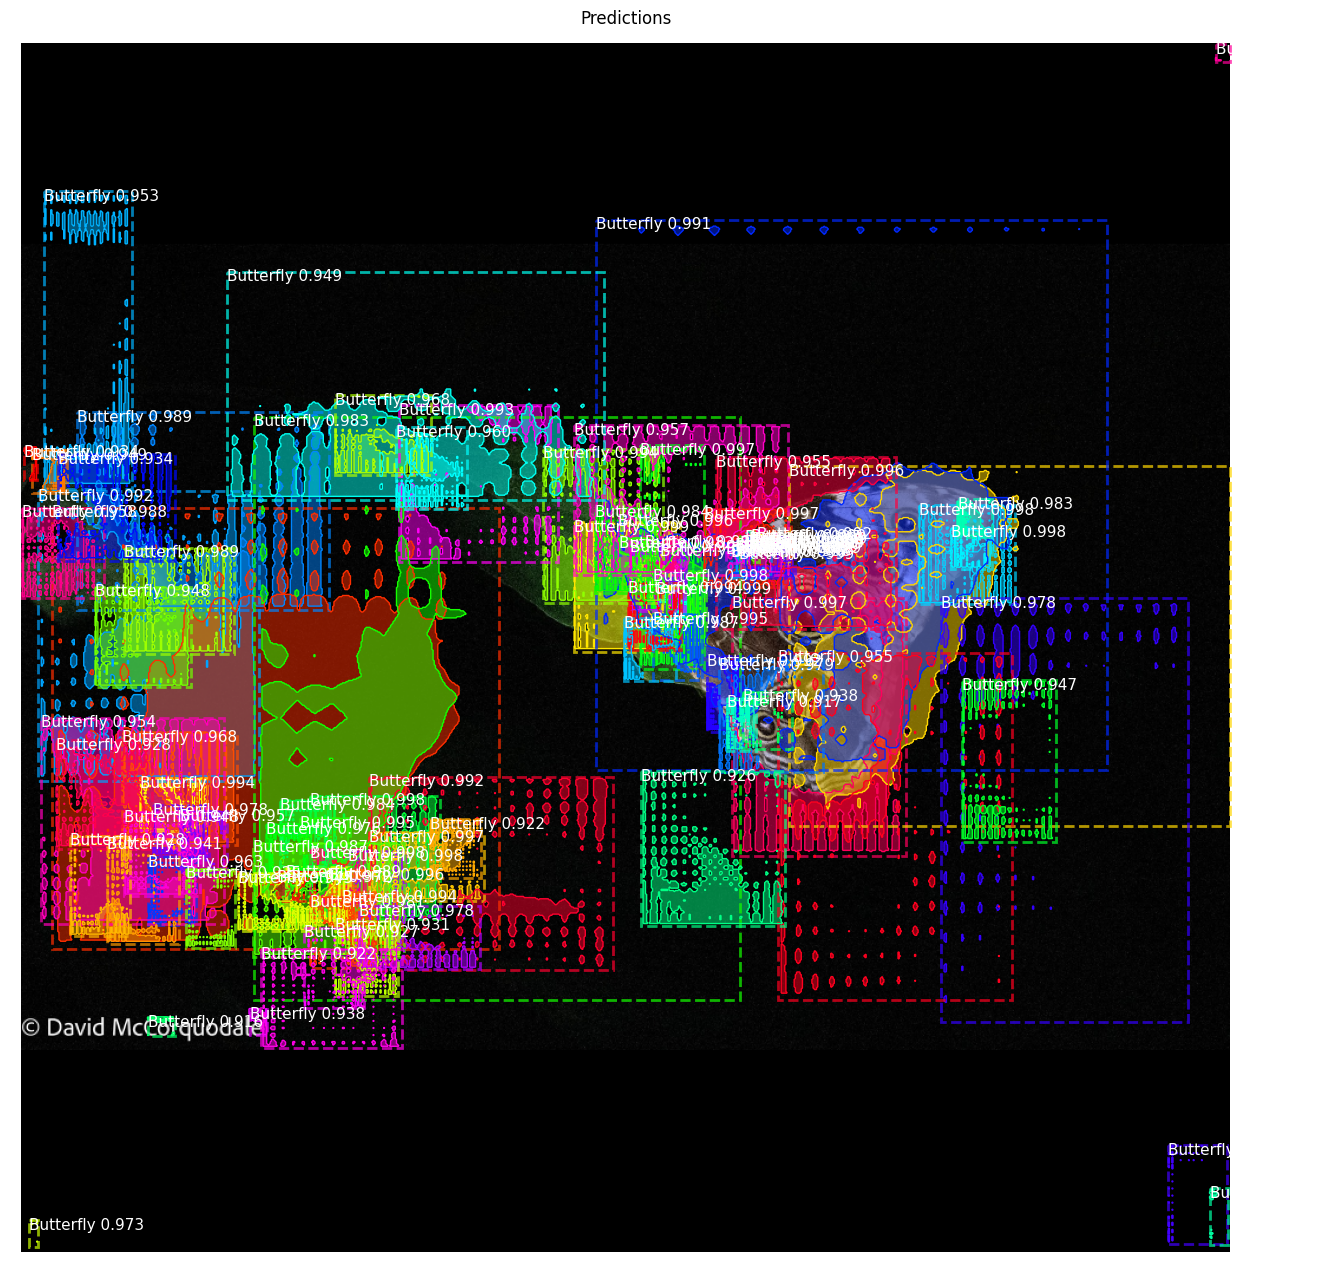

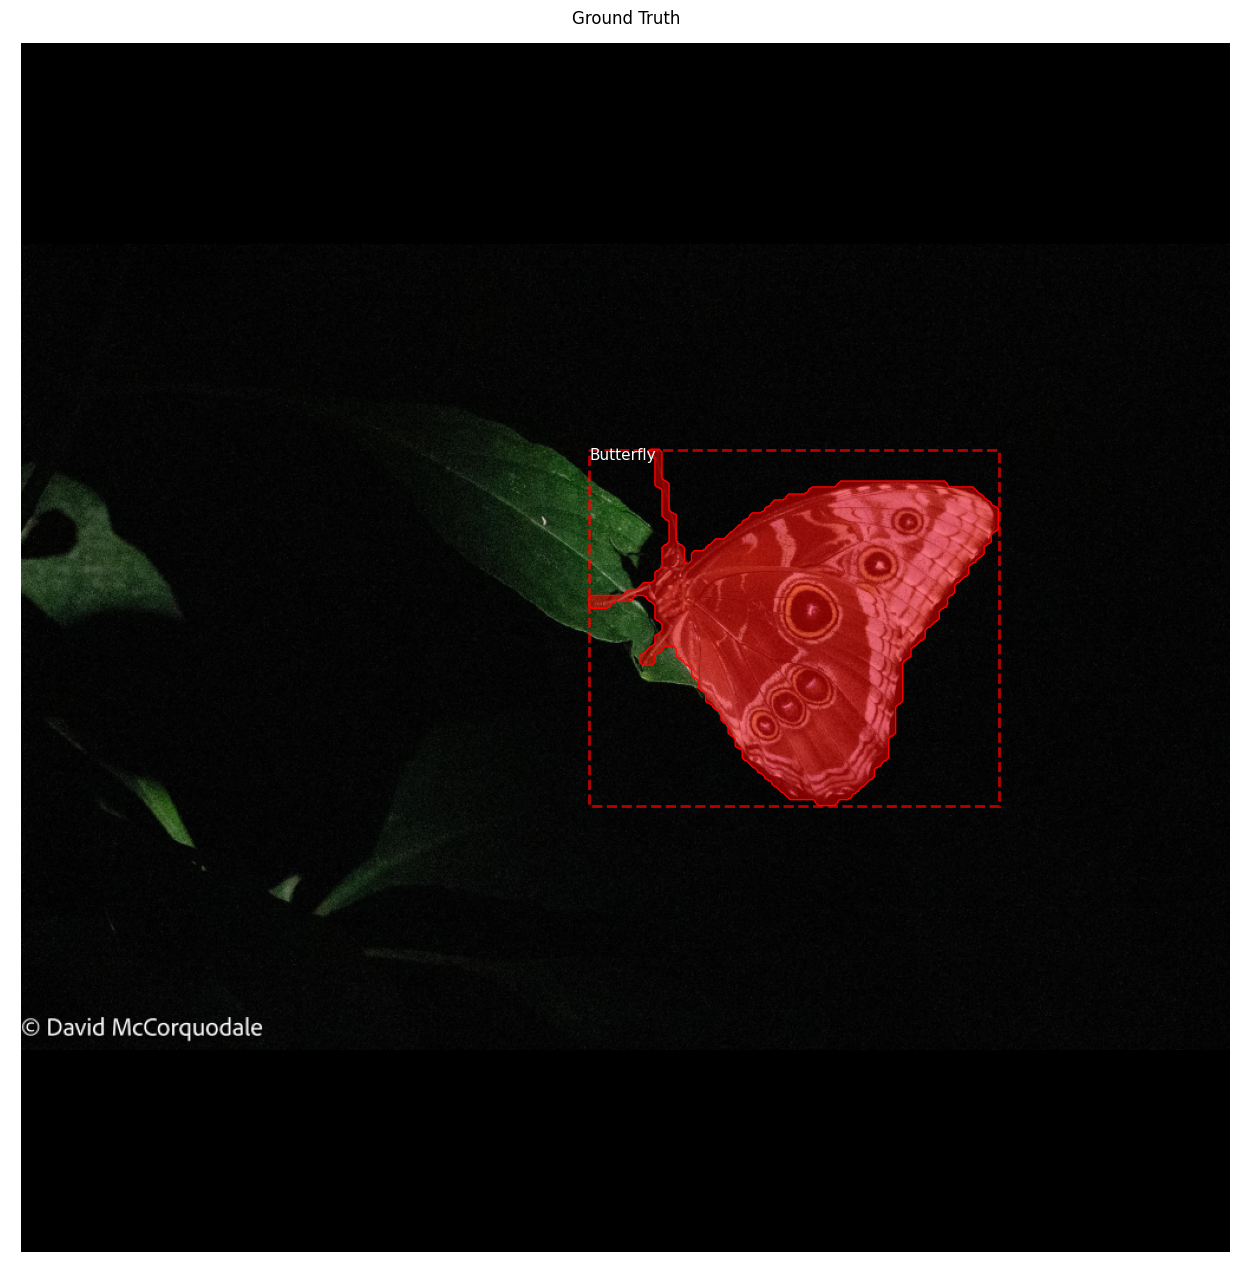

gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  344.00000  max:  828.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


In [8]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

results = model.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

visualize.display_instances(
    image,
    gt_bbox,
    utils.expand_mask(gt_bbox, gt_mask, image.shape[:2]),
    gt_class_id,
    dataset.class_names,
    title="Ground Truth"
)

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)